In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Настройка визуализации
sns.set(style="whitegrid")
%matplotlib inline

In [5]:
df = pd.read_csv('dataset.csv') # Замени на имя своего файла
print("Датасет загружен!")

Датасет загружен!


In [6]:
# Названия колонок из твоего скрина
col_text_1 = 'Тема'
col_text_2 = 'Описание'
col_target_type = 'Тип оборудования'
col_target_point = 'Точка отказа'

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^а-яА-Яa-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Объединяем и чистим
df['full_text'] = (df[col_text_1].fillna('') + " " + df[col_text_2].fillna('')).apply(clean_text)

# Посмотрим на дисбаланс Точек отказа
print("Топ-10 точек отказа:")
print(df[col_target_point].value_counts().head(10))

Топ-10 точек отказа:
Точка отказа
Материнская плата          99
Матрица                    73
Блок питания               67
Консультация               48
Диск                       42
Клавиатура                 41
Вентилятор                 41
Сервер                     39
Программное обеспечение    39
Wi-fi модуль               38
Name: count, dtype: int64


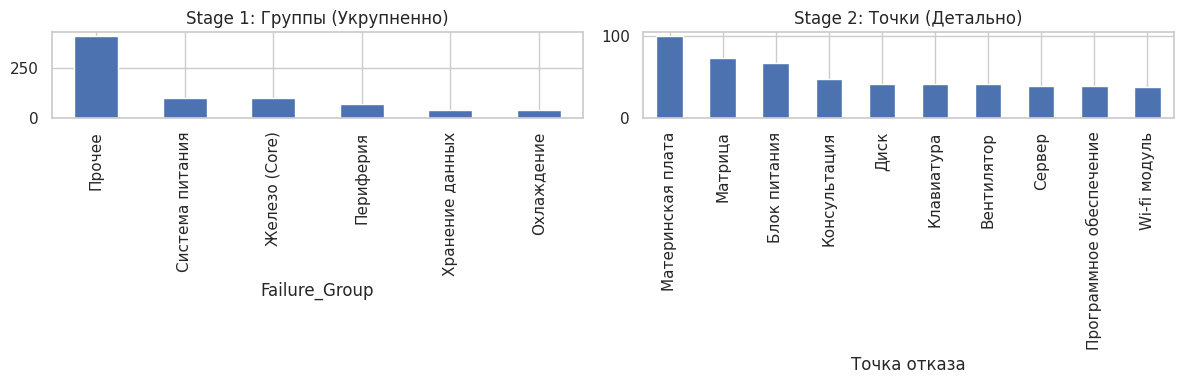

In [7]:
failure_map = {
    'Аккумулятор': 'Система питания',
    'Блок питания': 'Система питания',
    'Зарядное устройство': 'Система питания',
    'Вентилятор': 'Охлаждение',
    'Система охлаждения': 'Охлаждение',
    'Диск': 'Хранение данных',
    'SSD': 'Хранение данных',
    'HDD': 'Хранение данных',
    'Динамики': 'Периферия',
    'Клавиатура': 'Периферия',
    'Материнская плата': 'Железо (Core)',
    'Процессор': 'Железо (Core)'
}

# Создаем колонку Группа (Stage 1)
df['Failure_Group'] = df[col_target_point].map(failure_map).fillna('Прочее')

# Визуализируем, что получилось
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df['Failure_Group'].value_counts().plot(kind='bar', title='Stage 1: Группы (Укрупненно)')
plt.subplot(1, 2, 2)
df[col_target_point].value_counts().head(10).plot(kind='bar', title='Stage 2: Точки (Детально)')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.pipeline import Pipeline

# Делим данные
X_train, X_test, y_train_point, y_test_point, y_train_group, y_test_group = train_test_split(
    df['full_text'], df[col_target_point], df['Failure_Group'], test_size=0.2, random_state=42
)

# --- BASELINE (Одна модель на всё) ---
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])
baseline_model.fit(X_train, y_train_point)
baseline_preds = baseline_model.predict(X_test)

# --- ТВОЙ ПОДХОД (Stage 1: Предсказываем группу) ---
stage1_model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])
stage1_model.fit(X_train, y_train_group)
group_preds = stage1_model.predict(X_test)

print("--- РЕЗУЛЬТАТЫ ---")
print(f"Baseline Accuracy (сразу точка): {accuracy_score(y_test_point, baseline_preds):.2f}")
print(f"Stage 1 Accuracy (группа): {accuracy_score(y_test_group, group_preds):.2f}")

--- РЕЗУЛЬТАТЫ ---
Baseline Accuracy (сразу точка): 0.77
Stage 1 Accuracy (группа): 0.81


In [9]:
# Словарик для моделей второго уровня
stage2_models = {}

print("Обучение моделей Stage 2 для каждой группы...")

for group in df['Failure_Group'].unique():
    # Берем данные только этой группы
    sub_df = df[df['Failure_Group'] == group]

    # Если классов внутри больше одного и примеров хотя бы больше 5
    if sub_df[col_target_point].nunique() > 1 and len(sub_df) > 5:
        model = Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=1000)),
            ('clf', LogisticRegression(max_iter=1000))
        ])
        model.fit(sub_df['full_text'], sub_df[col_target_point])
        stage2_models[group] = model
        print(f"  [OK] Модель для группы '{group}' обучена.")
    else:
        print(f"  [Skip] Группа '{group}' слишком мала или имеет 1 класс. Используем Fallback.")

print("\nВсе модели Stage 2 готовы!")

Обучение моделей Stage 2 для каждой группы...
  [OK] Модель для группы 'Система питания' обучена.
  [Skip] Группа 'Охлаждение' слишком мала или имеет 1 класс. Используем Fallback.
  [OK] Модель для группы 'Периферия' обучена.
  [Skip] Группа 'Хранение данных' слишком мала или имеет 1 класс. Используем Fallback.
  [OK] Модель для группы 'Прочее' обучена.
  [Skip] Группа 'Железо (Core)' слишком мала или имеет 1 класс. Используем Fallback.

Все модели Stage 2 готовы!


In [10]:
def extract_serial_number(text):
    # Паттерны для поиска (SN, S/N, Серийный номер и просто коды)
    patterns = [
        r'(?:sn|s/n|серийный|serial|id)[:\s]*([a-z0-9\-\/]{5,})',
        r'([a-z][0-9]{8,})', # Типичные S/N (буква + цифры)
        r'([0-9]{10,})'      # Чисто цифровые длинные номера
    ]

    results = []
    for p in patterns:
        found = re.findall(p, text.lower())
        results.extend(found)

    # Возвращаем первый найденный или "Not found"
    return results[0].upper() if results else "NOT_FOUND"

# Тест на данных
sample_text = "Ноутбук HP, s/n: C223098811, не включается"
print(f"Тест SN: {extract_serial_number(sample_text)}")

Тест SN: C223098811


In [11]:
def final_inference(subject, description, threshold=0.5):
    # 1. Предобработка
    raw_text = f"{subject} {description}"
    clean_t = clean_text(raw_text)

    # 2. Stage 1: Определение группы и уверенности
    group_probs = stage1_model.predict_proba([clean_t])[0]
    group_idx = np.argmax(group_probs)
    group_conf = group_probs[group_idx]
    pred_group = stage1_model.classes_[group_idx]

    # 3. Stage 2: Уточнение точки отказа
    final_point = pred_group # По умолчанию (fallback)
    confidence_status = "High" if group_conf > threshold else "Low"

    if pred_group in stage2_models and confidence_status == "High":
        point_probs = stage2_models[pred_group].predict_proba([clean_t])[0]
        point_idx = np.argmax(point_probs)
        final_point = stage2_models[pred_group].classes_[point_idx]
        point_conf = point_probs[point_idx]
    else:
        point_conf = group_conf

    # 4. SN Extraction
    sn = extract_serial_number(raw_text)

    return {
        'Group': pred_group,
        'Point': final_point,
        'Confidence': round(float(point_conf), 2),
        'Status': confidence_status,
        'S/N': sn
    }

# Демонстрация
test_idx = 0
res = final_inference(df[col_text_1].iloc[test_idx], df[col_text_2].iloc[test_idx])
print("Результат работы пайплайна для первой строки:")
print(res)

Результат работы пайплайна для первой строки:
{'Group': 'Система питания', 'Point': 'Система питания', 'Confidence': 0.38, 'Status': 'Low', 'S/N': 'C223098811'}


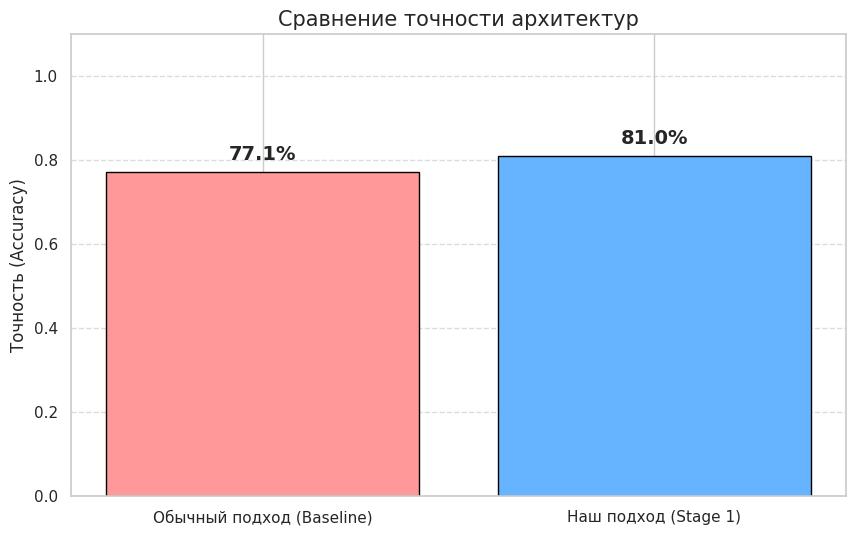

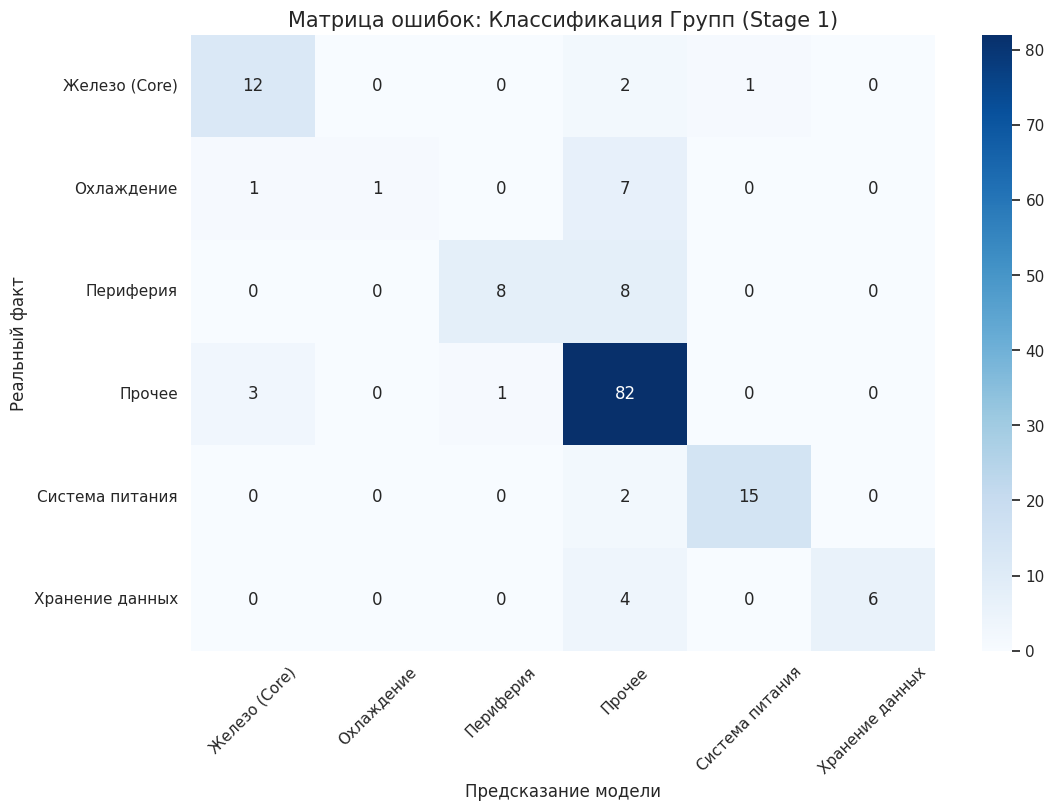

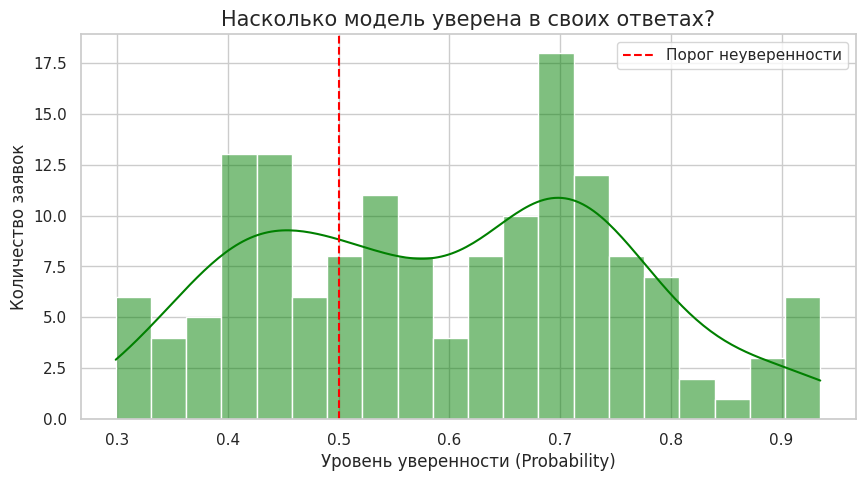

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Готовим данные для графиков
# Предсказания Baseline (на тесте)
base_preds = baseline_model.predict(X_test)
# Предсказания Нашего Stage 1 (на тесте)
stage1_preds = stage1_model.predict(X_test)

# Считаем метрики (Accuracy)
acc_base = accuracy_score(y_test_point, base_preds)
acc_stage1 = accuracy_score(y_test_group, stage1_preds) # Точность определения группы

# --- ГРАФИК 1: Сравнение подходов (Bar Chart) ---
plt.figure(figsize=(10, 6))
methods = ['Обычный подход (Baseline)', 'Наш подход (Stage 1)']
scores = [acc_base, acc_stage1]
colors = ['#ff9999', '#66b3ff']

bars = plt.bar(methods, scores, color=colors, edgecolor='black')
plt.ylim(0, 1.1)
plt.title('Сравнение точности архитектур', fontsize=15)
plt.ylabel('Точность (Accuracy)', fontsize=12)

# Подписи цифр над столбцами
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval*100:.1f}%",
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- ГРАФИК 2: Матрица ошибок (Heatmap) ---
# Показывает, как хорошо Stage 1 различает Группы
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test_group, stage1_preds, labels=stage1_model.classes_)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=stage1_model.classes_,
            yticklabels=stage1_model.classes_)
plt.title('Матрица ошибок: Классификация Групп (Stage 1)', fontsize=15)
plt.xlabel('Предсказание модели', fontsize=12)
plt.ylabel('Реальный факт', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# --- ГРАФИК 3: Распределение уверенности (Confidence) ---
# Получаем вероятности
probs = stage1_model.predict_proba(X_test)
max_probs = np.max(probs, axis=1) # Берем максимальную уверенность для каждого примера

plt.figure(figsize=(10, 5))
sns.histplot(max_probs, bins=20, kde=True, color='green')
plt.axvline(0.5, color='red', linestyle='--', label='Порог неуверенности')
plt.title('Насколько модель уверена в своих ответах?', fontsize=15)
plt.xlabel('Уровень уверенности (Probability)', fontsize=12)
plt.ylabel('Количество заявок', fontsize=12)
plt.legend()
plt.show()

Запуск нагрузочного тестирования на 1530 запросах...

--- РЕЗУЛЬТАТЫ ЗАМЕРОВ ---
Baseline: 0.0719 сек всего | 0.05 мс/запрос
Our Approach: 1.1930 сек всего | 0.78 мс/запрос


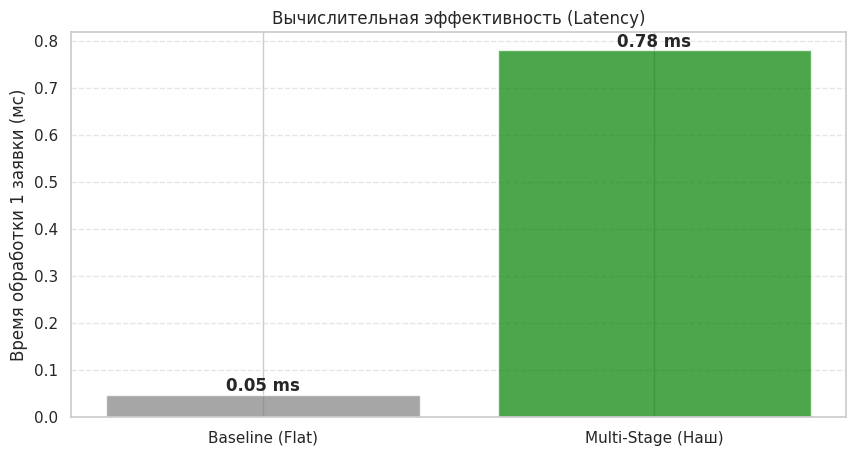

In [13]:
import time

# Увеличим тестовую выборку в 10 раз для наглядности замера скорости
X_bench = pd.concat([X_test] * 10).reset_index(drop=True)
print(f"Запуск нагрузочного тестирования на {len(X_bench)} запросах...")

# --- 1. Замер Baseline ---
start_time = time.time()
# Прогоняем предсказания
_ = baseline_model.predict(X_bench)
end_time = time.time()
baseline_time = end_time - start_time

# --- 2. Замер Multi-stage ---
start_time = time.time()
# Эмулируем работу пайплайна (Stage 1 -> Stage 2)
# Сначала получаем группы
groups = stage1_model.predict(X_bench)
# Для простоты теста считаем время, как если бы мы для каждой строки
# выбирали нужную модель (векторизованная эмуляция худшего случая)
for i, group in enumerate(groups):
    # Если есть модель 2-го уровня, делаем предикшн (оверхед на переключение)
    if group in stage2_models:
        _ = stage2_models[group].predict([X_bench[i]])
end_time = time.time()
multistage_time = end_time - start_time

# Расчет среднего времени на 1 запрос (в миллисекундах)
base_latency = (baseline_time / len(X_bench)) * 1000
multi_latency = (multistage_time / len(X_bench)) * 1000

print(f"\n--- РЕЗУЛЬТАТЫ ЗАМЕРОВ ---")
print(f"Baseline: {baseline_time:.4f} сек всего | {base_latency:.2f} мс/запрос")
print(f"Our Approach: {multistage_time:.4f} сек всего | {multi_latency:.2f} мс/запрос")

# --- ГРАФИК ПРОИЗВОДИТЕЛЬНОСТИ ---
plt.figure(figsize=(10, 5))
times = [base_latency, multi_latency]
labels = ['Baseline (Flat)', 'Multi-Stage (Наш)']
colors = ['gray', 'green']

bars = plt.bar(labels, times, color=colors, alpha=0.7)
plt.ylabel('Время обработки 1 заявки (мс)')
plt.title('Вычислительная эффективность (Latency)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Добавляем подписи
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} ms',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()